# Tarea KMeans y Shap
## Arantza Gomez Haro Gamboa

In [75]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
from xgboost import XGBClassifier
from xgboost import plot_importance
import shap 
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.pipeline import Pipeline

In [76]:
def calibracion_multiple(modelos, y, bins):
    for nombre, predicciones in modelos.items():
        df_calibracion = pd.DataFrame({
            'predicciones': predicciones,
            'y': y
        })
        
        df_calibracion['bins'] = pd.qcut(df_calibracion['predicciones'], q=bins, labels=False, duplicates='drop') + 1
        grouped = df_calibracion.groupby('bins').mean()
        
        plt.figure()
    
        plt.plot(grouped.predicciones, grouped.y, label=f"{nombre} (Modelo)", marker="o", color="rosybrown")
        plt.plot(grouped.predicciones, grouped.predicciones, label="Real", marker="o", color="cornflowerblue")
        
        plt.grid()
        plt.legend()
        plt.xlabel("Predicción")
        plt.ylabel("Real")
        plt.title(f"Calibración para {nombre}")

### **Datos**

In [77]:
df = pd.read_csv('titanic.csv')
df = df.drop(columns=['PassengerId', 'Name', 'Ticket', 'Cabin'])
df = pd.get_dummies(df)
df.head()

,Survived,Pclass,Age,SibSp,Parch,Fare,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S
0,0,3,22.0,1,0,7.2500,False,True,False,False,True
1,1,1,38.0,1,0,71.2833,True,False,True,False,False
2,1,3,26.0,0,0,7.9250,True,False,False,False,True
3,1,1,35.0,1,0,53.1000,True,False,False,False,True
4,0,3,35.0,0,0,8.0500,False,True,False,False,True


In [78]:
target = 'Survived'
y = df[target]
X = df.copy()
X = X.drop(target, axis = 1)
X.head()

,Pclass,Age,SibSp,Parch,Fare,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S
0,3,22.0,1,0,7.2500,False,True,False,False,True
1,1,38.0,1,0,71.2833,True,False,True,False,False
2,3,26.0,0,0,7.9250,True,False,False,False,True
3,1,35.0,1,0,53.1000,True,False,False,False,True
4,3,35.0,0,0,8.0500,False,True,False,False,True


In [79]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### **XGBoost**

In [80]:
model = XGBClassifier(
    n_estimators = 100_000,
    max_depth = 5,
    learning_rate = 0.1,
    reg_lambda = 0.1,
    subsample = 0.5,
    col_sample_by_tree = 0.8,
    tree_method = 'hist',
    early_stopping_rounds = 40,
    eval_metric = "auc"
)

model.fit(X_train, y_train, eval_set = [(X_train, y_train), (X_test, y_test)], verbose = 100)

[0]	validation_0-auc:0.87455	validation_1-auc:0.81609
[100]	validation_0-auc:0.97796	validation_1-auc:0.88044
[122]	validation_0-auc:0.98321	validation_1-auc:0.88211


c:\Users\arant\anaconda3\Lib\site-packages\xgboost\callback.py:386: UserWarning: [23:17:21] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "col_sample_by_tree" } are not used.

  self.starting_round = model.num_boosted_rounds()


XGBClassifier(base_score=None, booster=None, callbacks=None,
              col_sample_by_tree=0.8, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None, device=None,
              early_stopping_rounds=40, enable_categorical=False,
              eval_metric='auc', feature_types=None, feature_weights=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100000, n_jobs=None, ...)

#### *AUC:*

In [81]:
predicciones_xg = model.predict_proba(X_test)[:,1]
roc_auc_score(y_score=predicciones_xg, y_true=y_test)

0.883912483912484

#### *Gráfica de Calibración:*

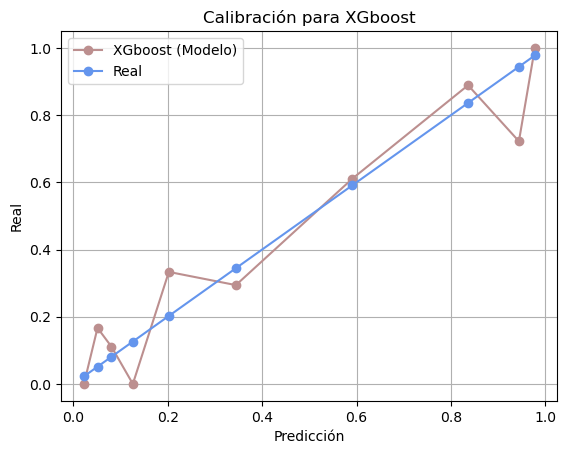

In [82]:
modelo = {
    'XGboost': predicciones_xg,
}

calibracion_multiple(modelo, y_test, bins=10)

##### *ROC Curve:*

#### *Feature Importance:*

<Axes: title={'center': 'Feature importance'}, xlabel='Importance score', ylabel='Features'>

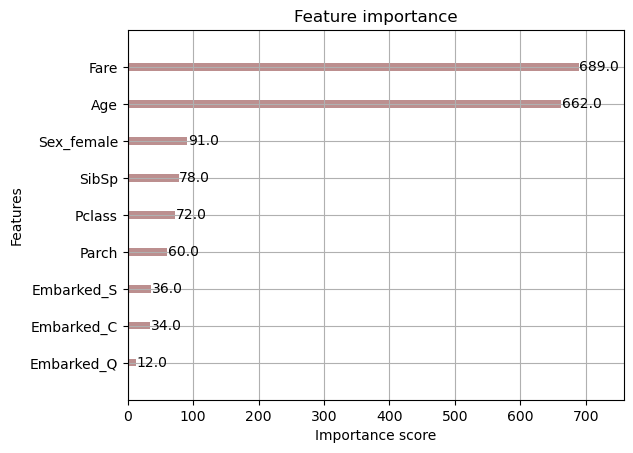

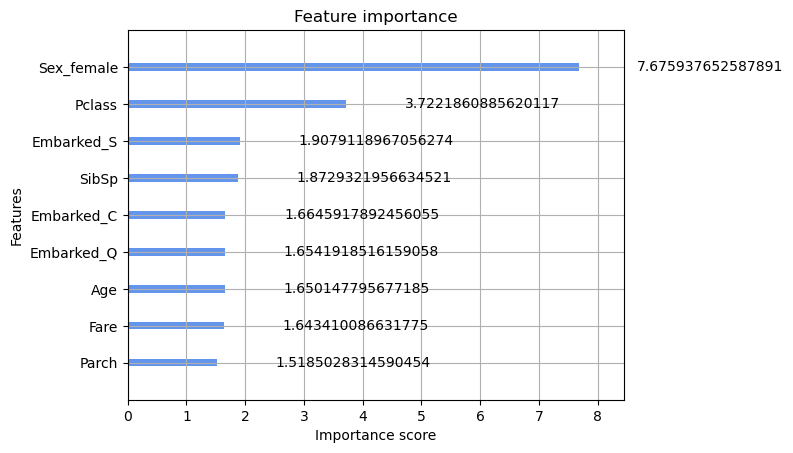

In [83]:
plot_importance(model, max_num_features=10, importance_type="weight", color = 'rosybrown')
plot_importance(model, max_num_features=10, importance_type="gain", color = 'cornflowerblue')

##### *Análisis:*

- 

### **Shap Values para una Predicción**

In [84]:
len(X_test)

179

In [85]:
X_shap = X_test.sample(175, random_state=42)

explainer = shap.TreeExplainer(model)

shap_values = explainer.shap_values(X_shap)

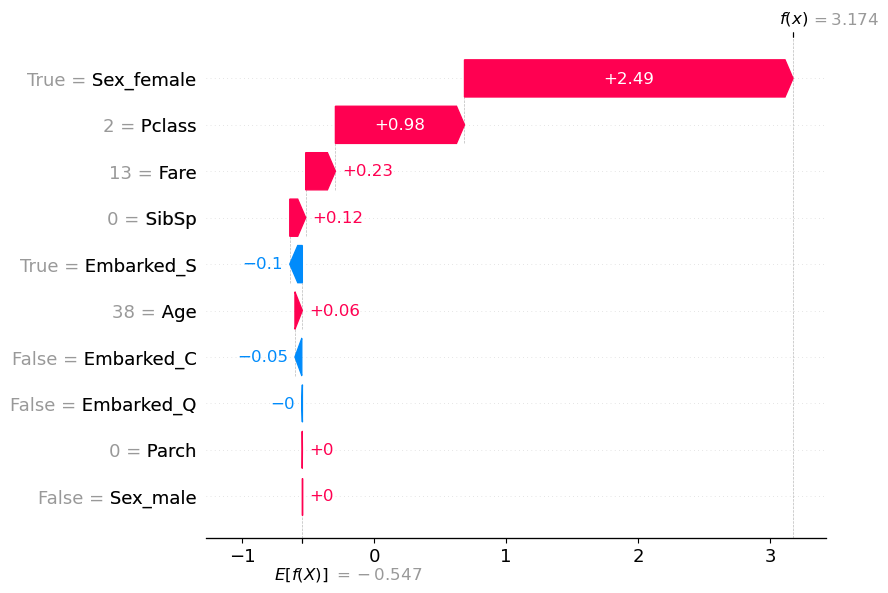

In [86]:
shap.initjs()

shap.plots.waterfall(shap.Explanation(
    values = shap_values[0],
    base_values = explainer.expected_value,
    data = X_shap.iloc[0],
    feature_names = X_shap.keys()
))


##### *Análisis:*

### **Shap Values Generales**

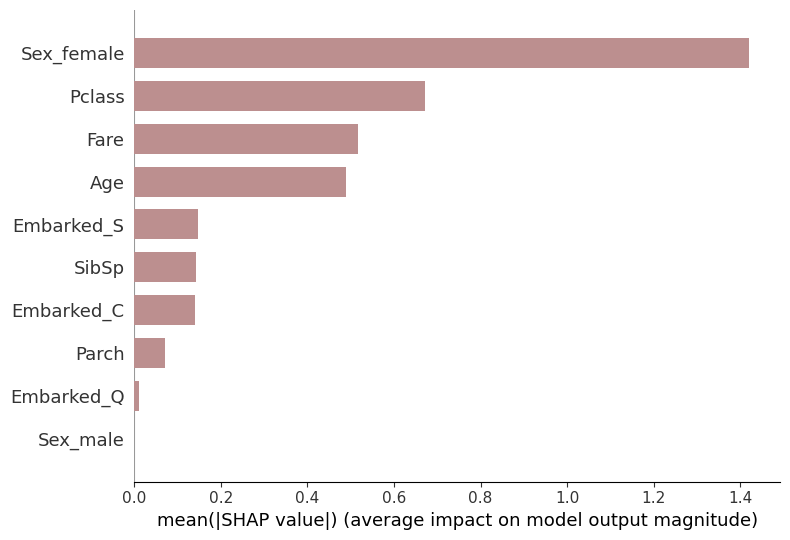

In [87]:
shap.summary_plot(shap_values, X_shap, plot_type="bar", max_display = 10, color = "rosybrown")

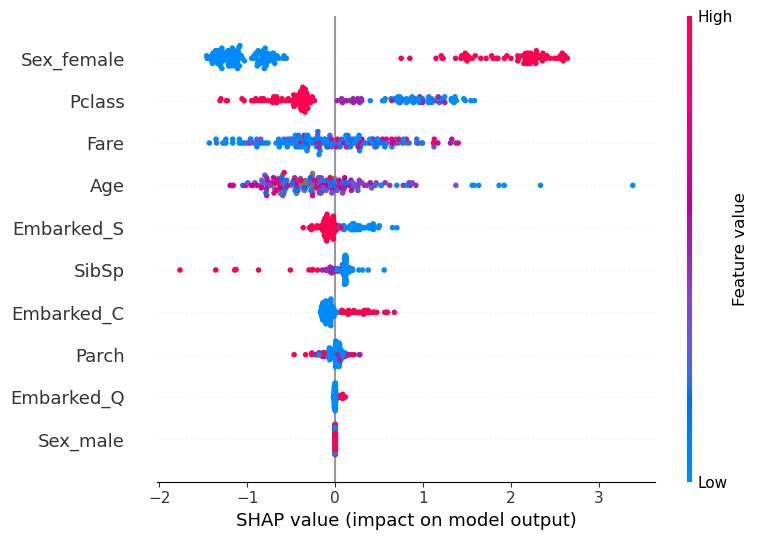

In [88]:
shap.summary_plot(shap_values, X_shap, plot_type="dot")

##### *Análisis:*

### **KMeans y Método del Codo**

##### *Método del codo:*

In [89]:
df.dropna(axis=0, inplace = True)

c:\Users\arant\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(
c:\Users\arant\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(
c:\Users\arant\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(
c:\Users\arant\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Window

Text(0, 0.5, 'Loss Function')

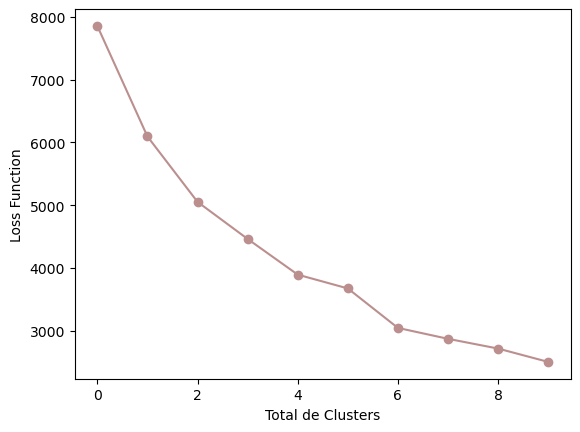

In [90]:
inertias = []

K_range = range(1, 11)
for i in K_range:
    pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('kmeans', KMeans(n_clusters=i, random_state = 42))
    ])
    pipeline.fit(df)
    inertias.append(pipeline.named_steps['kmeans'].inertia_)

plt.plot(inertias, marker = "o", c = "rosybrown")
plt.xlabel("Total de Clusters")
plt.ylabel("Loss Function")

##### *Análisis:*

##### *KMeans:*

In [91]:
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('kmeans', KMeans(n_clusters=3))
])

pipeline.fit(df)

c:\Users\arant\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


Pipeline(steps=[('scaler', StandardScaler()), ('kmeans', KMeans(n_clusters=3))])

In [92]:
df['cluster'] = pipeline.predict(df)

### **Características Generales del Cluster**

##### *Suma de cada variable por cluster:*

In [96]:
df.groupby('cluster').sum()

,Survived,Pclass,Age,SibSp,Parch,Fare,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S
cluster,,,,,,,,,,,
0,79,227,4005.92,55,54,8878.5797,61,69,130,0,0
1,69,931,11642.25,178,100,8350.3907,0,384,0,16,368
2,142,439,5557.00,133,154,7542.9126,200,0,0,12,186


##### *Promedio de cada variable por cluster:*

In [97]:
df.groupby('cluster').mean()

,Survived,Pclass,Age,SibSp,Parch,Fare,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S
cluster,,,,,,,,,,,
0,0.607692,1.746154,30.814769,0.423077,0.415385,68.296767,0.469231,0.530769,1.0,0.000000,0.000000
1,0.179688,2.424479,30.318359,0.463542,0.260417,21.745809,0.000000,1.000000,0.0,0.041667,0.958333
2,0.710000,2.195000,27.785000,0.665000,0.770000,37.714563,1.000000,0.000000,0.0,0.060000,0.930000


##### *Análisis:*